# Research Workflow

This notebook demonstrates the research [workflow](https://langchain-ai.github.io/langgraph/tutorials/workflows/) that creates comprehensive reports through a series of focused steps. The system:

1. Uses a **graph workflow** with specialized nodes for each report creation stage
2. Enables user **feedback and approval** at critical planning points 
3. Produces a well-structured report with introduction, researched body sections, and conclusion

## From repo 

In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/Users/lynn/Library/Mobile Documents/com~apple~CloudDocs/Work Files/Turmeric/Twinkl/edu_intel_digest/open_deep_research/src


## From package 

In [2]:
! pip install -U -q open-deep-research


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


# Compile the Graph-Based Research Workflow

The next step is to compile the LangGraph workflow that orchestrates the report creation process. This defines the sequence of operations and decision points in the research pipeline.

In [3]:
# Import required modules and initialize the builder from open_deep_research
import uuid 
import os, getpass
import open_deep_research   
print(open_deep_research.__version__) 
from IPython.display import Image, display, Markdown
from langgraph.types import Command
from langgraph.checkpoint.memory import MemorySaver
from open_deep_research.graph import builder

from dotenv import load_dotenv
load_dotenv()

0.0.15


True

In [4]:
# Create a memory-based checkpointer and compile the graph
# This enables state persistence and tracking throughout the workflow execution

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

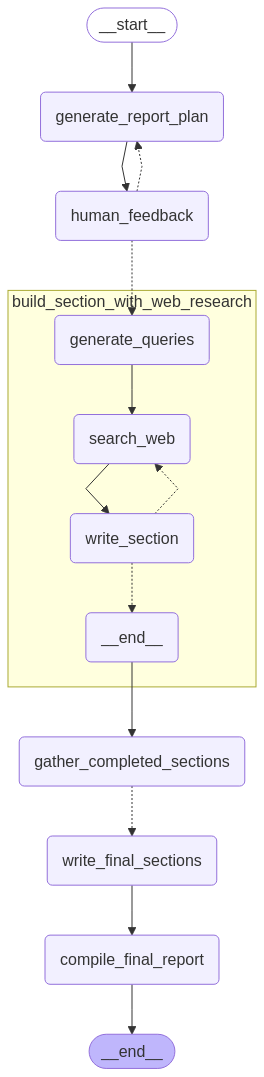

In [5]:
# Visualize the graph structure
# This shows the nodes and edges in the research workflow

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [6]:
# Helper function to set environment variables for API keys
# This ensures all necessary credentials are available for various services

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# Set the API keys used for any model or search tool selections below, such as:
_set_env("OPENAI_API_KEY")
_set_env("ANTHROPIC_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("GROQ_API_KEY")
_set_env("PERPLEXITY_API_KEY")

In [7]:
# Define report structure template and configure the research workflow
# This sets parameters for models, search tools, and report organization

REPORT_STRUCTURE = """

Use this structure to create a report on the user-provided topic:

**Weekly K-12 Educational Development Digest**

---

**Texas Educational Developments:**

* **Significant Shifts:**
    * [Concise summary of key policy/legislative changes, new state initiatives, or major trend shifts in Texas education. Max 5 bullet points.]
* **Accolades:**
    * [Concise summary of notable recognition or positive achievements within Texas education. Max 3 bullet point.]
* **Controversies:**
    * [Concise summary of significant debates, conflicts, or legal challenges in Texas education. Max 3 bullet points.]
* **Competitor Movements (Digital/EdTech):**
    * [Concise summary of notable activities by digital/edtech resource providers specifically impacting or targeting the Texas market. Mention the competitor and their action. Max 3 bullet points.]

---

**Florida Educational Developments:**

* **Significant Shifts:**
    * [Concise summary of key policy/legislative changes, new state initiatives, or major trend shifts in Florida education. Max 5 bullet points.]
* **Accolades:**
    * [Concise summary of notable recognition or positive achievements within Florida education. Max 3 bullet point.]
* **Controversies:**
    * [Concise summary of significant debates, conflicts, or legal challenges in Florida education. Max 3 bullet points.]
* **Competitor Movements (Digital/EdTech):**
    * [Concise summary of notable activities by digital/edtech resource providers specifically impacting or targeting the Florida market. Mention the competitor and their action. Max 3 bullet points.]

---

"""

# Configuration option 1: Claude 3.7 Sonnet for planning with perplexity search
thread = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "search_api": "perplexity",
                           "planner_provider": "anthropic",
                           "planner_model": "claude-3-7-sonnet-latest",
                           # "planner_model_kwargs": {"temperature":0.8}, # if set custom parameters
                           "writer_provider": "anthropic",
                           "writer_model": "claude-3-5-sonnet-latest",
                           # "writer_model_kwargs": {"temperature":0.8}, # if set custom parameters
                           "max_search_depth": 2,
                           "report_structure": REPORT_STRUCTURE,
                           }}

# Configuration option 2: DeepSeek-R1-Distill-Llama-70B for planning and llama-3.3-70b-versatile for writing
thread = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "search_api": "tavily",
                           "planner_provider": "groq",
                           "planner_model": "deepseek-r1-distill-llama-70b",
                           "writer_provider": "groq",
                           "writer_model": "llama-3.3-70b-versatile",
                           "report_structure": REPORT_STRUCTURE,
                           "max_search_depth": 1,}
                           }

# Configuration option 3: Use OpenAI o3 for both planning and writing (selected option)
thread = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "search_api": "tavily",
                           "planner_provider": "openai",
                           "planner_model": "o3",
                           "writer_provider": "openai",
                           "writer_model": "o3",
                           "max_search_depth": 2,
                           "report_structure": REPORT_STRUCTURE,
                           }}

# Define research topic about Model Context Protocol
topic = "Conduct research on K-12 education in Texas and Florida for April-March 2025. Identify significant policy shifts, notable accolades, key controversies, and movements by digital/edtech resource providers. Focus on gathering information relevant for strategic decision-making purposes"

# Run the graph workflow until first interruption (waiting for user feedback)
async for event in graph.astream({"topic":topic,}, thread, stream_mode="updates"):
    if '__interrupt__' in event:
        interrupt_value = event['__interrupt__'][0].value
        display(Markdown(interrupt_value))

Please provide feedback on the following report plan. 
                        

Section: Introduction
Description: Briefly state the purpose of the Weekly K-12 Educational Development Digest, scope (April–March 2025), and how the information is organized for strategic decision-makers.
Research needed: No


Section: Texas Educational Developments (April–March 2025)
Description: Present concise bullet-point coverage of significant policy shifts, accolades, controversies, and competitor (digital/EdTech) movements affecting Texas K-12 education.
Research needed: Yes


Section: Florida Educational Developments (April–March 2025)
Description: Present concise bullet-point coverage of significant policy shifts, accolades, controversies, and competitor (digital/EdTech) movements affecting Florida K-12 education.
Research needed: Yes


Section: Cross-State Comparison & Strategic Implications
Description: Compare the Texas and Florida findings, highlight converging or diverging trends, and outline actionable insights for stakeholders (e.g., market opportunities, regulatory risks, partnership prospects).
Research needed: Yes


Section: Conclusion
Description: Summarize key takeaways and recommend next steps for monitoring or engagement through the next quarter.
Research needed: No


                        
Does the report plan meet your needs?
Pass 'true' to approve the report plan.
Or, provide feedback to regenerate the report plan:

# User Feedback Phase

* This allows for providing directed feedback on the initial report plan
* The user can review the proposed report structure and provide specific guidance
* The system will incorporate this feedback into the final report plan

In [8]:
# Submit feedback on the report plan
# The system will continue execution with the updated requirements

# Provide specific feedback to focus and refine the report structure
async for event in graph.astream(Command(resume="Perfect. Just don't write an intro."), thread, stream_mode="updates"):
    if '__interrupt__' in event:
        interrupt_value = event['__interrupt__'][0].value
        display(Markdown(interrupt_value))

Please provide feedback on the following report plan. 
                        

Section: Texas Educational Developments Digest (Apr 2024 – Mar 2025)
Description: Compile weekly bullet-point updates on significant policy shifts, accolades, controversies, and competitor/EdTech movements in Texas K-12 education for the defined period. Output will follow the mandated sub-structure for fast executive review.
Research needed: Yes


Section: Florida Educational Developments Digest (Apr 2024 – Mar 2025)
Description: Compile weekly bullet-point updates on significant policy shifts, accolades, controversies, and competitor/EdTech movements in Florida K-12 education for the defined period. Output will follow the mandated sub-structure for fast executive review.
Research needed: Yes


Section: Cross-State Comparative Insights & Strategic Recommendations
Description: Analyze converging and diverging trends between Texas and Florida; identify strategic risks/opportunities for decision-makers, especially around policy alignment, market entry timing, and EdTech positioning.
Research needed: No


                        
Does the report plan meet your needs?
Pass 'true' to approve the report plan.
Or, provide feedback to regenerate the report plan:

# Final Approval Phase
* After incorporating feedback, approve the plan to start content generation

In [9]:
# Approve the final plan and execute the report generation
# This triggers the research and writing phases for all sections

# The system will now:
# 1. Research each section topic
# 2. Generate content with citations
# 3. Create introduction and conclusion
# 4. Compile the final report

async for event in graph.astream(Command(resume=True), thread, stream_mode="updates"):
    print(event)
    print("\n")

{'human_feedback': None}


{'build_section_with_web_research': {'completed_sections': [Section(name='Texas Educational Developments Digest (Apr 2024 – Mar 2025)', description='Compile weekly bullet-point updates on significant policy shifts, accolades, controversies, and competitor/EdTech movements in Texas K-12 education for the defined period. Output will follow the mandated sub-structure for fast executive review.', research=True, content='## Texas Educational Developments Digest (Apr 2024 – Mar 2025)\n\n• 10 Jan 25 – TEA posts the Preliminary 2025 Accountability Manual for comment, signaling no new A-F cut-score changes through 2026 and outlining pairing rules for alternative campuses [1].  \n• 13 Jan 25 – CoSN/AASA “Strategic Technology Planning” edLeader panel airs; Texas district CTOs demonstrate new TCO and VOI calculators now free to LEAs via TETL [3].  \n• 23 Jan 25 – TEA releases its 2024 Annual Report, highlighting progress on 88th-session mandates and stressing further inv

In [10]:
# Display the final generated report
# Retrieve the completed report from the graph's state and format it for display

final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

## Texas Educational Developments Digest (Apr 2024 – Mar 2025)

• 10 Jan 25 – TEA posts the Preliminary 2025 Accountability Manual for comment, signaling no new A-F cut-score changes through 2026 and outlining pairing rules for alternative campuses [1].  
• 13 Jan 25 – CoSN/AASA “Strategic Technology Planning” edLeader panel airs; Texas district CTOs demonstrate new TCO and VOI calculators now free to LEAs via TETL [3].  
• 23 Jan 25 – TEA releases its 2024 Annual Report, highlighting progress on 88th-session mandates and stressing further investment in teacher quality and early-literacy supports [2].  
• 04 Feb 25 – At the TCEA 2025 convention, Judson, Lockhart and Crandall ISDs tell peers that device-leasing models are helping offset post-ESSER budget gaps and reduce break/fix staffing costs [4].  
• 14 Feb 25 – CoSN’s 2025 Driving K-12 Innovation report drops; Texas superintendents on the advisory board elevate “data privacy” and “AI enablers” as fast-track priorities for district tech plans [5].  
• 17 Mar 25 – TEA files the final Accountability Rating System Manual; an unchanged 2024 methodology is re-adopted, and the appeals window opens ahead of 06 Apr effective date [6].  
• 27 Mar 25 – Agency simultaneously posts a proposed ESSA Talent-Plan amendment, launching a public feedback period on strategies to correct inequitable teacher assignments [6].

### Sources  
[1] 2025 Accountability Rating System: https://tea.texas.gov/texas-schools/accountability/academic-accountability/performance-reporting/2025-accountability-rating-system  
[2] Texas Education Agency Releases 2024 Annual Report: https://tea.texas.gov/about-tea/news-and-multimedia/news-releases/news-2025/texas-education-agency-releases-2024-annual-report  
[3] Financing Technology Innovations – Strategies and Tools: https://www.tetl.org/articles/financing-technology-innovations-strategies-and-tools  
[4] TCEA 2025: Could Leasing Help Schools Meet Budget Challenges?: https://edtechmagazine.com/k12/article/2025/02/tcea-2025-could-leasing-help-schools-meet-budget-challenges  
[5] CoSN 2025 Driving K-12 Innovation Report: https://www.futurereadytx.org/cosn-2025-driving-k-12-innovation-report/  
[6] Final Accountability System Manual for 2025 Ratings and Proposed Amendment to ESSA State Plan: https://tea.texas.gov/about-tea/news-and-multimedia/correspondence/taa-letters/final-accountability-system-manual-for-2025-ratings-and-proposed-amendment-to-essa-state-plan

## Florida Educational Developments Digest (Apr 2024 – Mar 2025)

- Week of 6 May 2024: Florida K-12 AI Education Task Force launches, uniting districts with Google, Microsoft and others to draft voluntary classroom-AI guidance and training resources [1].  
- Week of 9 Jul 2024: UF Education Policy Research Center brief distills 2024 K-12 bills on vouchers, later start-times and library challenges, triggering cabinet-level compliance reviews [2].  
- Week of 5 Aug 2024: New book-review rules, universal vouchers and mandatory communism lessons take effect; media centers rush to update inventories and curricula for 2024-25 [3].  
- Week of 27 Jan 2025: FETC 2025 in Orlando spotlights AI adoption; Miami-Dade’s selective AI Institute and district Gemini licenses draw wide interest, intensifying vendor jockeying for micro-credential programs [4].  
- Week of 5 Feb 2025: CoSN unveils its 2025 Driving K-12 Innovation report; Florida CTOs mine data-governance and AI-literacy chapters to steer post-ESSER device refresh plans [5].  
- Week of 3 Mar 2025: Legislative session opens; Moms for Libros tracker monitors bills on teacher pay, mental-health supports and gun safety, giving districts early fiscal scenarios [6].  

### Sources  
[1] Florida AI K-12 Taskforce Home: https://fl-aitaskforce.org/  
[2] Florida’s Education in Focus: Navigating the 2024 K-12 Legislative Landscape: https://education.ufl.edu/eprc/2024/07/09/floridas-education-in-focus-navigating-the-2024-k-12-legislative-landscape/  
[3] Florida education bills touch on book bans, school vouchers ... – WUSF: https://www.wusf.org/education/2024-03-15/florida-education-bills-touch-on-book-bans-school-vouchers-identity-politics-and-more  
[4] FETC 2025: Ways To Bring AI into your K-12 District: https://edtechmagazine.com/k12/article/2025/01/fetc-2025-ways-bring-ai-your-k-12-district  
[5] Driving K-12 Innovation: Explore Our 2025 Digital Report – CoSN: https://www.cosn.org/driving-k-12-innovation-explore-our-2025-digital-report/  
[6] Florida Legislative Session 2025: Tracking Education Legislation … – Moms for Libros: https://www.momsforlibros.org/florida_legislative_session_2025_tracking_education_legislation_that_impacts_public_schools_and_children

# Cross-State Comparative Insights & Strategic Recommendations

Texas and Florida together educate one-fifth of U.S. K-12 students and increasingly shape national EdTech demand. This section distills lessons from April 2024–March 2025 developments in both states to guide leaders on timing, product fit and risk. We map where policies are converging, where they diverge and what that means for market entry, investment and partnership choices. The goal: turn fragmented weekly headlines into actionable strategy.

### Converging Trends

* AI accelerates on both fronts: Texas CTOs elevate privacy-first “AI enablers,” while Florida launches a statewide AI Task Force and district-level Gemini pilots.  
* Districts confront post-ESSER cliffs; leasing or opex procurement models gain favor (Judson ISD successes in TX, Miami-Dade interest in FL).  
* CoSN 2025 report serves as a shared playbook, framing data-governance and innovation language that vendors can mirror in proposals.

### Diverging Trends

* Regulatory volatility: Texas freezes A-F cut scores through 2026, but Florida’s 2024-25 statutes overhaul vouchers, library vetting and civic curricula.  
* Culture-war temperature: Florida’s “book review” and “mandatory communism lessons” heighten content-compliance risk; Texas debates remain muted.  
* Fiscal flow: Texas keeps formula funding intact; Florida’s universal vouchers shift dollars from districts to families, complicating district budgets.

### Strategic Risks

1. Florida content scrutiny can trigger sudden bans; non-aligned vendors face reputational and legal exposure.  
2. Voucher expansion may dilute district purchasing power, slowing sales cycles for large footprint deployments.  
3. In Texas, dependence on teacher-quality initiatives means PD-heavy solutions must prove direct links to mastery gains or risk sidelining.

### Opportunities & Recommendations

* Package AI-powered analytics with turnkey PD that maps to both TEA teacher-quality goals and Florida’s AI micro-credential push.  
* Lead with opex-friendly financing: highlight Texas leasing case studies while modeling voucher-influenced demand curves for Florida.  
* Embed configurable content-filtering and library-challenge dashboards to meet Florida’s compliance environment and position as a low-risk partner.

## Summary & Next Steps

| Axis | Texas | Florida | Strategic Implication |
|---|---|---|---|
| Policy trajectory | Stable accountability; teacher-quality focus | Rapid statutory churn: vouchers, book vetting, civic mandates | Leverage stability for quick TX pilots; build FL flexibility clauses |
| AI & Data priorities | Privacy-centric AI tools promoted at TETL/TCEA | State AI Task Force, district Gemini pilots, micro-credentialing | Offer common AI core with state-specific PD wrappers |
| Funding & procurement | Device-leasing offsets budget dips | Voucher flow reshapes purchasing authority | Position opex models in TX; create family-facing tiers for FL |
| Stakeholder friction | Low cultural pushback | High book-challenge activism | Integrate robust content-governance for FL launches |

Act now by prioritizing Texas to secure reference implementations during its stable cycle, while finalizing a compliance-ready, modular product line for Florida ahead of the 2025 legislative outcomes.

Trace: 

> Note: uses 80k tokens 

https://smith.langchain.com/public/31eca7c9-beae-42a3-bef4-5bce9488d7be/r